In [2]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [3]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from pathlib import Path
import multiprocessing as mp
import roicat
%load_ext autoreload
%autoreload 2
import roicat.util

This notebook is for visualization of the results of an ROICaT run. You can play with different inclusion criteria here, and also combine classification and tracking results to view the intersection of the two.

In [ ]:
# Load the result

use_classificationResults = False
results = roicat.util.RichFile_ROICaT(path=r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\Notebooks\results\result.tracking.results_all.richfile").load()  # result path
if use_classificationResults:
    results_classification = roicat.util.RichFile_ROICaT(path='/media/rich/bigSSD/data_tmp/test_data/mouse_1.classification_drawn.run_data.richfile').load()
else:
    results_classification = None

In [32]:
# Load Fluorescence data
path_list = [r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\session_1\F.npy", r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\session_2\F.npy"] # list of planes fluorescence data
fluorescence_data = []
for npy_file_path in path_list:
    data = np.load(npy_file_path)
    fluorescence_data.append(data)  # add all fluorescence data to a list

Step 1: Remove bad ROIs using iscell mask

In [ ]:
# Apply the iscell mask

iscell_list = [r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\session_1\isredcell.npy", r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\session_2\iscell.npy"] # list of planes of iscell data
iscell = []
for npy_file_path in iscell_list:
    data = np.load(npy_file_path)
    list = []
    for d in data:
        if d[1] > 0.5:    # if the probability that it is a cell is alrger than 0.5
            list.append(True)
        else:
            list.append(False)   # convert the 0/1 & probability in iscell file from suite2p into True or False
    iscell.append(list)  # add all iscell data to a list
    
roi_labels = results['clusters']['labels_bySession']

## Get the iscell masked labels
labels_iscell = roicat.util.mask_UCIDs_with_iscell(
    ucids=roi_labels,
    iscell=iscell,
)

## Squeeze the labels to remove the unassigned labels (not necessary, but reduces the number of unique labels)
labels_iscell = roicat.util.squeeze_UCID_labels(ucids=labels_iscell, return_array=True)  ## [(n_rois,)] * n_sessions

## Align the data without the masked labels
data_aligned = roicat.util.match_arrays_with_ucids(
    arrays=fluorescence_data, 
    ucids=roi_labels,
)

## Align the data with the iscell masks
data_aligned_masked_iscell = roicat.util.match_arrays_with_ucids(
    arrays= fluorescence_data,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=labels_iscell,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)

## Check the results
print("Original data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in fluorescence_data])
print('')
print("First aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned])
print('')
print("iscell masked aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned_masked_iscell])


Original data shapes [(n_rois, n_timepoints)] * n_sessions:
[(520, 2188), (433, 1785)]

First aligned data shapes [(n_rois, n_timepoints)] * n_sessions:
[(363, 2188), (363, 1785)]

iscell masked aligned data shapes [(n_rois, n_timepoints)] * n_sessions:
[(237, 2188), (237, 1785)]


In [39]:
# get the ids for each cluster after iscell masked
ucids = []  
for session in labels_iscell:
    for label in session:
        ucids.append(label)
ucids = np.array(ucids)
ucids_unique = np.unique(ucids[ucids>=0])

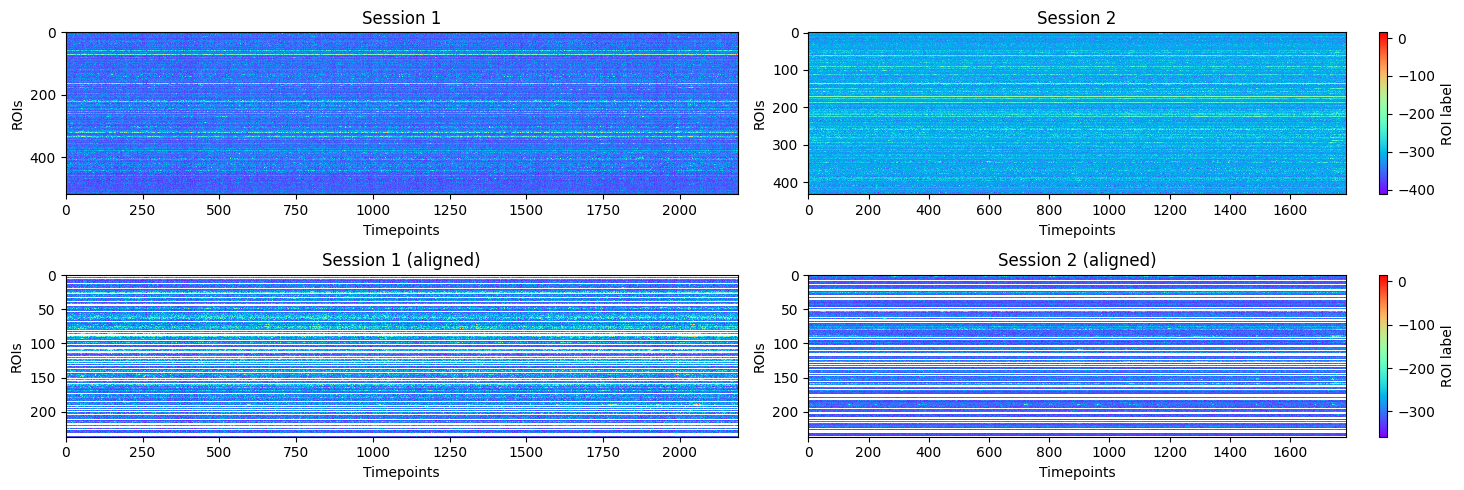

In [40]:
# plot the result --- row1 is raw data, row2 is the iscell masked data
n_sessions = 2   # number of sessions
fig, axs = plt.subplots(2, n_sessions, figsize=(15, 5))
for i in range(n_sessions):
    axs[0, i].imshow(fluorescence_data[i],         aspect="auto", cmap="rainbow", interpolation="none")
    axs[1, i].imshow(data_aligned_masked_iscell[i], aspect="auto", cmap="rainbow", interpolation="none")
    axs[0, i].set_title(f"Session {i+1}")
    axs[1, i].set_title(f"Session {i+1} (aligned)")
    axs[0, i].set_xlabel("Timepoints")
    axs[1, i].set_xlabel("Timepoints")
    axs[0, i].set_ylabel("ROIs")
    axs[1, i].set_ylabel("ROIs")
    ## Colorbar
    if i == n_sessions - 1:
        fig.colorbar(axs[0, i].imshow(fluorescence_data[i], aspect="auto", cmap="rainbow", interpolation="none"), ax=axs[0, i], label="ROI label")
        fig.colorbar(axs[1, i].imshow(data_aligned_masked_iscell[i], aspect="auto", cmap="rainbow", interpolation="none"), ax=axs[1, i], label="ROI label")
plt.tight_layout()

Step 2: Remove clusters with fewer ROIs

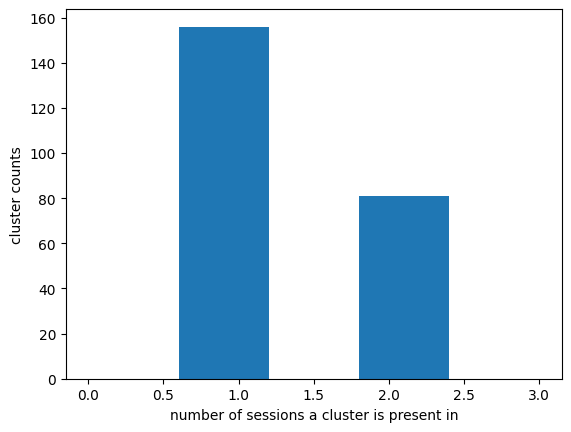

In [ ]:
# %matplotlib widget
_, counts = np.unique(ucids, return_counts=True)
n_sessions = len(results['clusters']['labels_bySession'])
plt.figure()
plt.hist(counts, bins=n_sessions*2 + 1, range=(0, n_sessions+1));
plt.xlabel('number of sessions a cluster is present in');
plt.ylabel('cluster counts');

# with the iscell mask, not all clusters appear in all sessions

INFO: 34.18% of UCIDs that appear in at least 2 sessions.


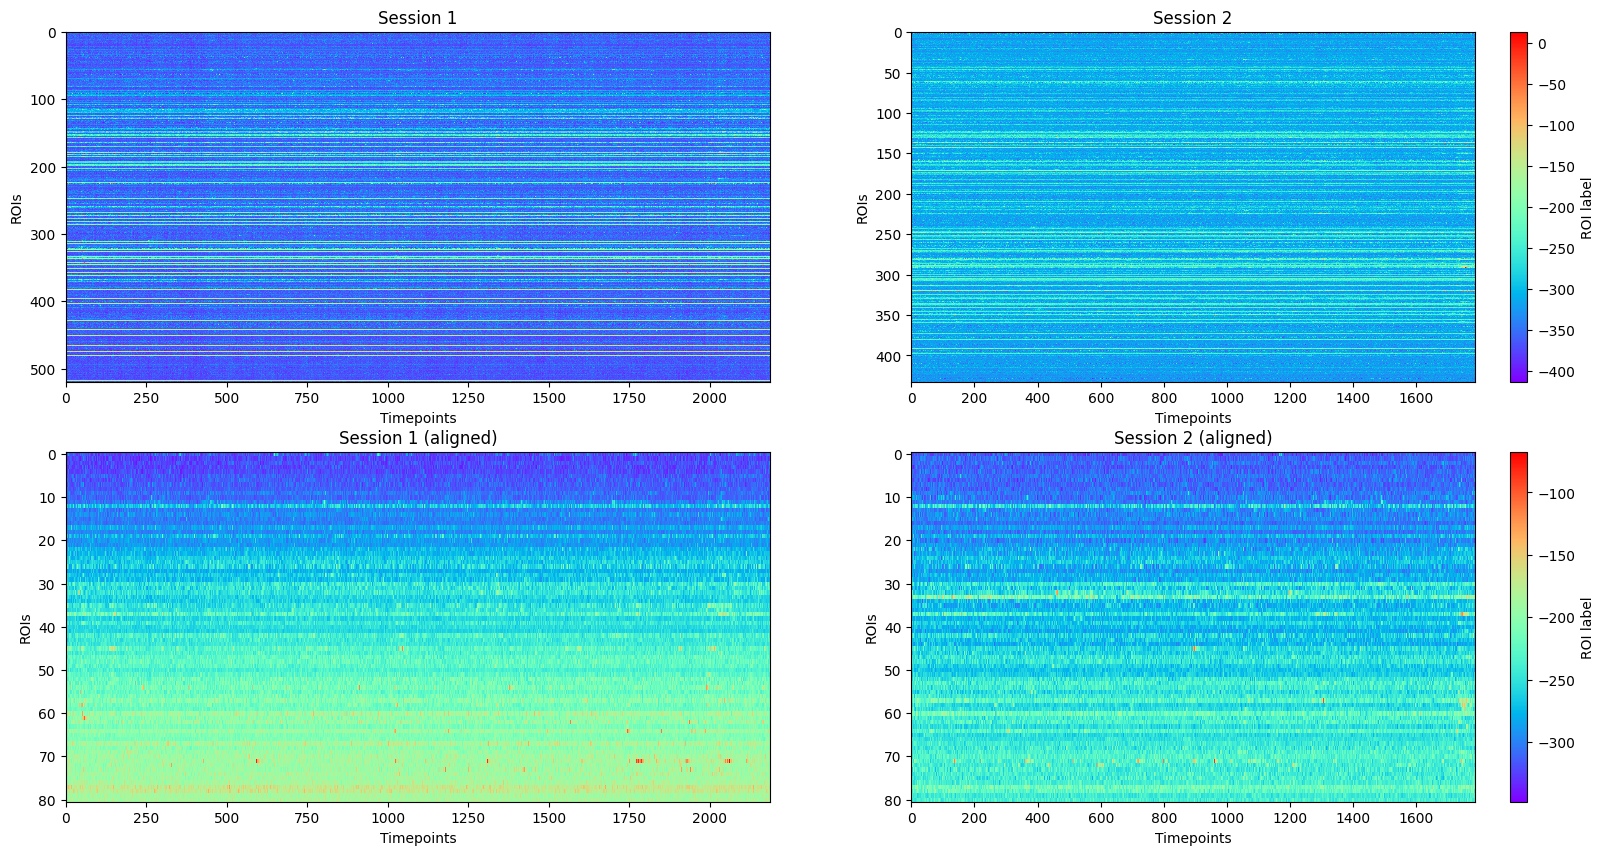

In [42]:
n_sessions_minimum = 2

## Remove labels / UCIDs that are not assigned in at least [n_sessions_minimum] sessions
labels_minSesh = roicat.util.discard_UCIDs_with_fewer_matches(
    ucids=labels_iscell,
    n_sesh_thresh=n_sessions_minimum,
)

## Squeeze the labels to remove the unassigned labels (not necessary, but reduces the number of unique labels)
labels_minSesh = roicat.util.squeeze_UCID_labels(ucids=labels_minSesh, return_array=True)  ## [(n_rois,)] * n_sessions

## Align the data with the masked labels
data_aligned_minSesh = roicat.util.match_arrays_with_ucids(
    arrays=fluorescence_data,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=labels_minSesh,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)

## Plot the results again
data_rainbow_minSesh = [d + r[:, None] for d, r in zip(fluorescence_data, labels_minSesh)]
data_rainbow_aligned_minSesh = roicat.util.match_arrays_with_ucids(
    arrays=data_rainbow_minSesh,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=labels_minSesh,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)
fig, axs = plt.subplots(2, n_sessions, figsize=(20, 10))
for i in range(n_sessions):
    axs[0, i].imshow(data_rainbow_minSesh[i],         aspect="auto", cmap="rainbow", interpolation="none")
    axs[1, i].imshow(data_rainbow_aligned_minSesh[i], aspect="auto", cmap="rainbow", interpolation="none")
    axs[0, i].set_title(f"Session {i+1}")
    axs[1, i].set_title(f"Session {i+1} (aligned)")
    axs[0, i].set_xlabel("Timepoints")
    axs[1, i].set_xlabel("Timepoints")
    axs[0, i].set_ylabel("ROIs")
    axs[1, i].set_ylabel("ROIs")
    ## Colorbar
    if i == n_sessions - 1:
        fig.colorbar(axs[0, i].imshow(data_rainbow_minSesh[i], aspect="auto", cmap="rainbow", interpolation="none"), ax=axs[0, i], label="ROI label")
        fig.colorbar(axs[1, i].imshow(data_rainbow_aligned_minSesh[i], aspect="auto", cmap="rainbow", interpolation="none"), ax=axs[1, i], label="ROI label")

Step 3: Use metrics for quality control

In [43]:
## List all available quality metrics and structure
print('Available quality metrics:')
display(results['clusters']['quality_metrics'].keys())
print(len(results['clusters']['quality_metrics']['cluster_silhouette']))  # silhouette scores for all clusters including the -1 cluster
print(len(results['clusters']['quality_metrics']['sample_silhouette'])) # sample sihouette scores for all ROIs
print(len(results['clusters']['labels']))  # labels for all ROIs in all session in one list
print(len(results['clusters']['labels_bySession'])) # split the labels by session

Available quality metrics:


dict_keys(['cluster_labels_unique', 'cluster_intra_means', 'cluster_intra_mins', 'cluster_intra_maxs', 'cluster_silhouette', 'sample_silhouette', 'hdbscan', 'sequentialHungarian'])

364
953
953
2


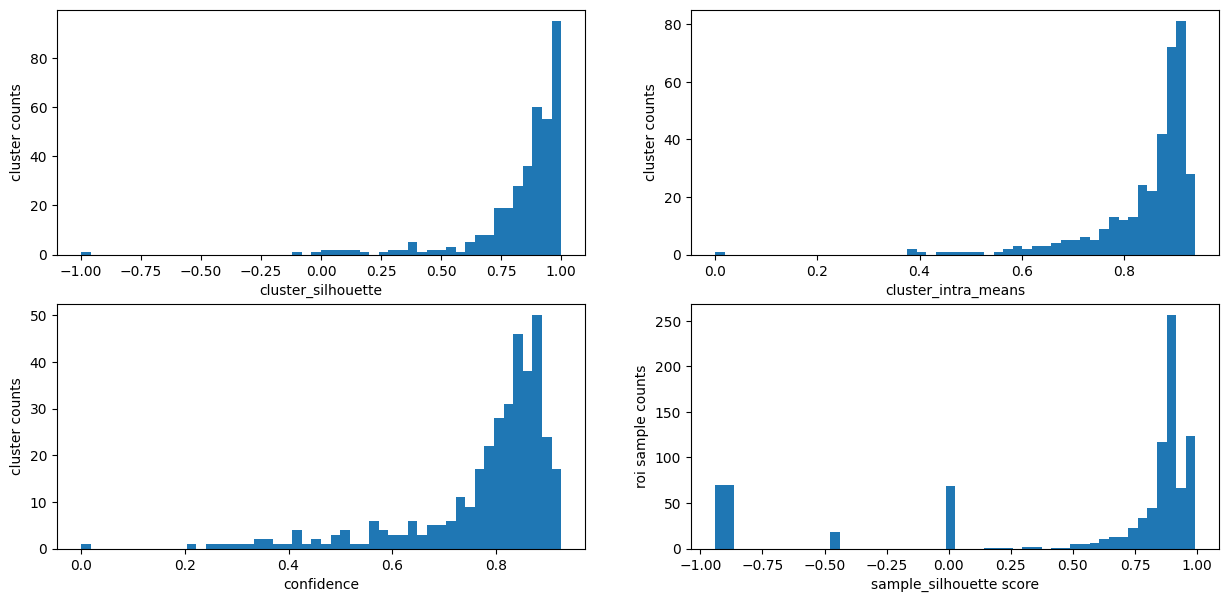

In [44]:
## Plot the distribution of the quality metrics

confidence = (((np.array(results['clusters']['quality_metrics']['cluster_silhouette']) + 1) / 2) * np.array(results['clusters']['quality_metrics']['cluster_intra_means']))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,7))

axs[0,0].hist(results['clusters']['quality_metrics']['cluster_silhouette'], 50);
axs[0,0].set_xlabel('cluster_silhouette');
axs[0,0].set_ylabel('cluster counts');

axs[0,1].hist(results['clusters']['quality_metrics']['cluster_intra_means'], 50);
axs[0,1].set_xlabel('cluster_intra_means');
axs[0,1].set_ylabel('cluster counts');

axs[1,0].hist(confidence, 50);
axs[1,0].set_xlabel('confidence');
axs[1,0].set_ylabel('cluster counts');

axs[1,1].hist(results['clusters']['quality_metrics']['sample_silhouette'], 50);
axs[1,1].set_xlabel('sample_silhouette score');
axs[1,1].set_ylabel('roi sample counts');

In [59]:
# Use Metrics for Quality Control
# Three criteria: cluster_sihouette, sample_sihouette, confidence

cluster_sihouette_threshold = 0.2
confidence_threshold = 0.8
sample_sihouette_threshold = 0.1

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

below_threshold_list = []
for idx in range(len(results['clusters']['quality_metrics']['cluster_silhouette'])):
    if results['clusters']['quality_metrics']['cluster_silhouette'][idx] < cluster_sihouette_threshold or confidence[idx] < confidence_threshold:  
        below_threshold_list.append(idx-1)
for idx in range(len(results['clusters']['quality_metrics']['sample_silhouette'])):
    if results['clusters']['quality_metrics']['sample_silhouette'][idx] < sample_sihouette_threshold:
        below_threshold_list.append(results['clusters']['labels'][idx])
below_threshold_list = np.unique(below_threshold_list)

labels_keep = []
for i in range(max(roi_labels[0])+1):
    if i not in below_threshold_list:
        labels_keep.append(i)

## Remove bad cluster labels
labels_masked_keep = roicat.util.mask_UCIDs_by_label(
    ucids=labels_minSesh, 
    labels=labels_keep,
)

# !!! Important !!! Use this one to remove bad cluster labels if you skip the first two steps
# labels_masked_keep = roicat.util.mask_UCIDs_by_label(
#     ucids=roi_labels, 
#     labels=labels_keep,
# )

## Squeeze the labels to remove the unassigned labels
labels_masked_keep = roicat.util.squeeze_UCID_labels(ucids=labels_masked_keep, return_array=True)  ## [(n_rois,)] * n_sessions

## Align the fluorescence data with the masked labels!!
data_aligned_masked_keep = roicat.util.match_arrays_with_ucids(
    arrays=fluorescence_data,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=labels_masked_keep,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)

## Check the results
print("Original data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in fluorescence_data])
print('')
print("First aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned])
print('')
print("iscell masked aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned_masked_iscell])
print('')
print('data_aligned_minSesh data shapes [(n_rois, n_timepoints)] * n_sessions:')
print([d.shape for d in data_aligned_minSesh])
print('')
print("labels_masked_keep aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned_masked_keep])

Original data shapes [(n_rois, n_timepoints)] * n_sessions:
[(520, 2188), (433, 1785)]

First aligned data shapes [(n_rois, n_timepoints)] * n_sessions:
[(363, 2188), (363, 1785)]

iscell masked aligned data shapes [(n_rois, n_timepoints)] * n_sessions:
[(237, 2188), (237, 1785)]

data_aligned_minSesh data shapes [(n_rois, n_timepoints)] * n_sessions:
[(81, 2188), (81, 1785)]

labels_masked_keep aligned data shapes [(n_rois, n_timepoints)] * n_sessions:
[(43, 2188), (43, 1785)]


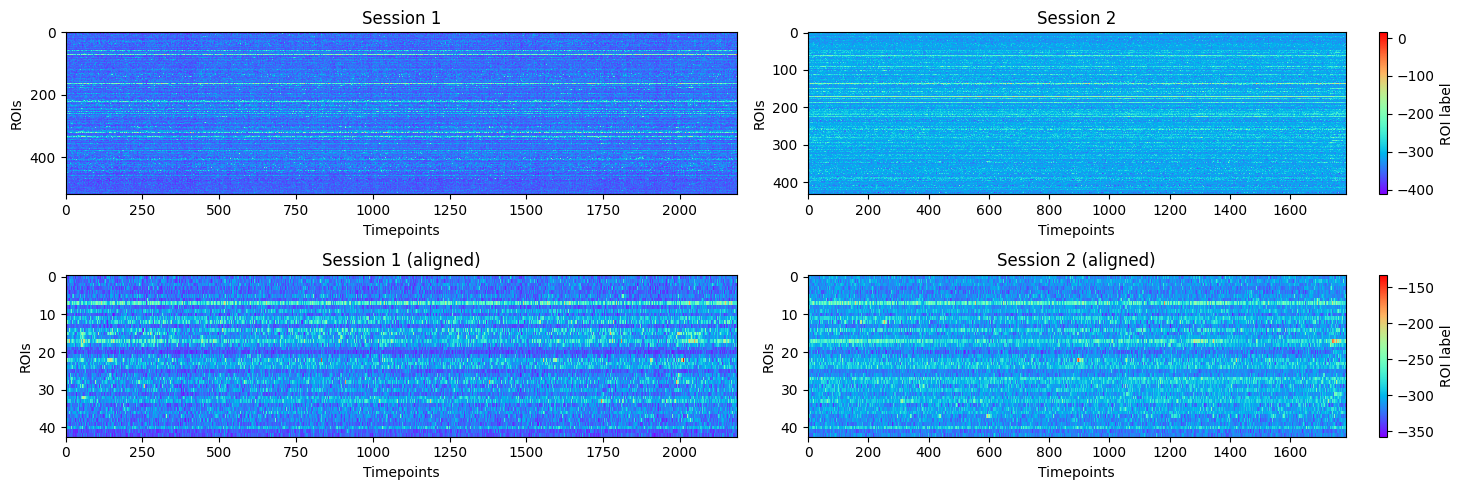

In [55]:
# plot the result again --- row1 is raw data, row2 is the aligned and masked data
n_sessions = 2   # number of sessions
fig, axs = plt.subplots(2, n_sessions, figsize=(15, 5))
for i in range(n_sessions):
    axs[0, i].imshow(fluorescence_data[i],         aspect="auto", cmap="rainbow", interpolation="none")
    axs[1, i].imshow(data_aligned_masked_keep[i], aspect="auto", cmap="rainbow", interpolation="none")
    axs[0, i].set_title(f"Session {i+1}")
    axs[1, i].set_title(f"Session {i+1} (aligned)")
    axs[0, i].set_xlabel("Timepoints")
    axs[1, i].set_xlabel("Timepoints")
    axs[0, i].set_ylabel("ROIs")
    axs[1, i].set_ylabel("ROIs")
    ## Colorbar
    if i == n_sessions - 1:
        fig.colorbar(axs[0, i].imshow(fluorescence_data[i], aspect="auto", cmap="rainbow", interpolation="none"), ax=axs[0, i], label="ROI label")
        fig.colorbar(axs[1, i].imshow(data_aligned_masked_keep[i], aspect="auto", cmap="rainbow", interpolation="none"), ax=axs[1, i], label="ROI label")
plt.tight_layout()

C:\Users\HAOXUAN YIN\AppData\Local\Temp\ipykernel_51284\3745536863.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(40,1))


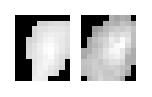

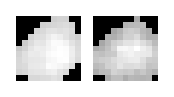

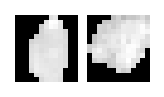

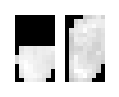

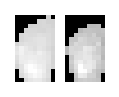

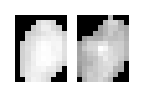

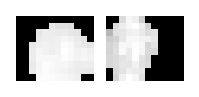

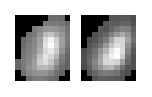

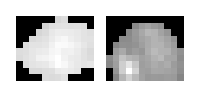

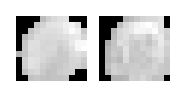

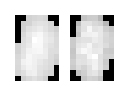

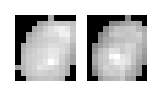

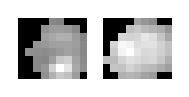

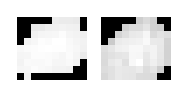

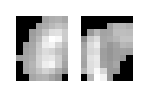

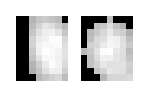

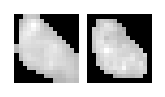

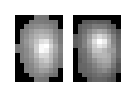

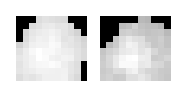

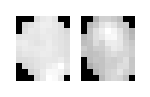

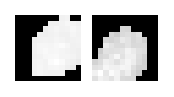

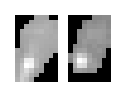

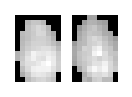

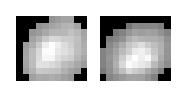

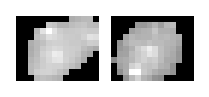

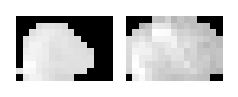

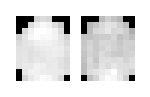

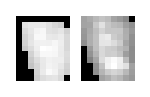

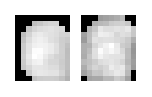

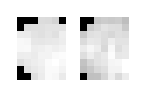

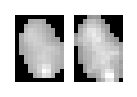

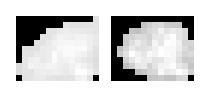

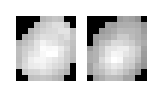

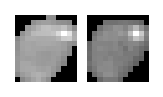

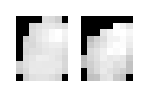

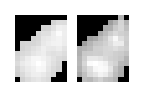

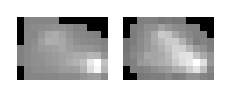

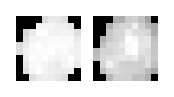

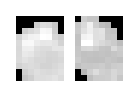

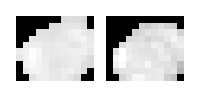

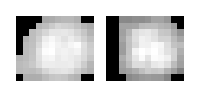

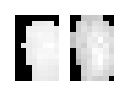

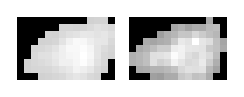

In [56]:
# Plot each cluster in different sessions

ucids = []  # get the ids for each cluster
for session in labels_masked_keep:
    for label in session:
        ucids.append(label)
ucids = np.array(ucids)
ucids_unique = np.unique(ucids[ucids>=0])

ROI_ims_sparse = scipy.sparse.vstack(results['ROIs']['ROIs_aligned'])
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()

ucid_sfCat = []  # image for all ucids stored in this list
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append(np.concatenate(roicat.visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), results['ROIs']['frame_height'], results['ROIs']['frame_width'])), axis=1) )

for ii in range(min(len(ucid_sfCat), 300)):
    plt.figure(figsize=(40,1))
    plt.imshow(ucid_sfCat[ii], cmap='gray')
    plt.axis('off')


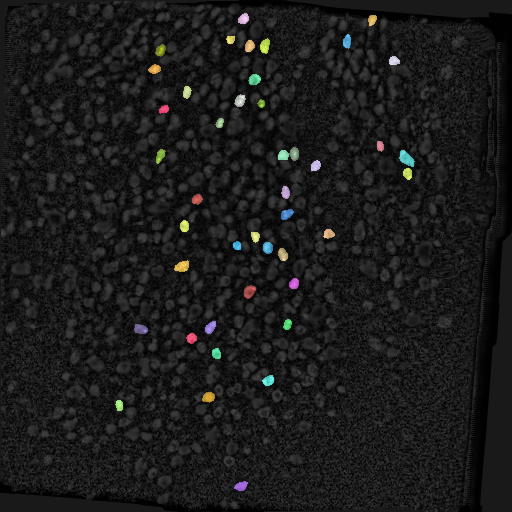

In [57]:
ims = np.load(r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\Notebooks\results\aligned_img.npy", allow_pickle=True)  # load the aligned image

labels = []
for session in labels_masked_keep:
    for label in session:
        labels.append(label)
labels = np.array(labels)

FOVs_colored = roicat.visualization.compute_colored_FOV(
    labels=labels,
    spatialFootprints=results['ROIs']['ROIs_aligned'], 
    FOV_height=results['ROIs']['frame_height'], 
    FOV_width=results['ROIs']['frame_width'], 
)

def to_rgb(img):
    """Convert grayscale (H, W) image to RGB (H, W, 3)"""
    if img.ndim == 2:
        return np.stack([img]*3, axis=-1)
    return img

def overlay_images(base_gray, overlay_rgb, alpha=0.6):
    """
    Overlay RGB mask on top of grayscale image.
    base_gray: (H, W), grayscale image
    overlay_rgb: (H, W, 3), color image
    alpha: blending factor for overlay
    """
    base_rgb = to_rgb(base_gray).astype(np.float32)
    overlay_rgb = overlay_rgb.astype(np.float32)
    
    # Normalize both to [0, 1] if not already
    if base_rgb.max() > 1.0:
        base_rgb /= 255.0
    if overlay_rgb.max() > 1.0:
        overlay_rgb /= 255.0

    blended = (1 - alpha) * base_rgb + alpha * overlay_rgb
    return np.clip(blended, 0, 1)  # Keep in float range [0, 1] for display

combined_images = [
    overlay_images(roicat_img, fov_img, alpha=0.6)
    for roicat_img, fov_img in zip(ims, FOVs_colored)]

roicat.visualization.display_toggle_image_stack(combined_images)